# Homework #8 (Due 11/06/2019, 11:59pm)
## Variational Inference for Bayesian Neural Networks

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2019**

**Name:** Cooper Lorsung

**Students collaborators:** Sujay Thakur, Jovin Leong, Brian Chu, Benjamin Levy

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
from autograd import numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
#from autograd.scipy.stats import bernoulli
import pandas as pd
import numpy
import matplotlib.pyplot as plt
#from nn_models import Feedforward
#from bayesian_regression import Bayesian_Regression
import sys
from tqdm import tqdm
%matplotlib inline

## Problem Description: Bayesian Neural Network Regression
In Homework #7, you explored sampling from the posteriors of ***Bayesian neural networks*** using HMC. In Lab #8 you'll explore the extent to which HMC can be inefficient or ineffective for sampling from certain types of posteriors. In this homework, you will study variational approximations of BNN posteriors, especially when compared to the posteriors obtained by sampling (in Homework #7). The data is the same as the one for Homework #7.


### Part I: Implement Black-Box Variational Inference with the Reparametrization Trick

1. (**BBVI with the Reparametrization Trick**) Implement BBVI with the reparametrization trick for approximating an arbitrary posterior $p(w| \text{Data})$ by an isotropic Gaussian $\mathcal{N}(\mu, \Sigma)$, where $\Sigma$ is a diagonal matrix. See Lecture #15 or the example code from [autograd's github repo](https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py). 
<br><br>

2. (**Unit Test**) Check that your implementation is correct by approximating the posterior of the following Bayesian logistic regression model:
\begin{align}
w &\sim \mathcal{N}(0, 1)\\
Y^{(n)} &\sim Ber(\text{sigm}(wX^{(n)} + 10))
\end{align}
  where $w$, $Y^{(n)}$, $X^{(n)}$ are a real scalar valued random variables, and where the data consists of a single observation $(Y=1, X=-20)$.

  The true posterior $p(w | Y=1, X=-20)$ should look like the following (i.e. the true posterior is left-skewed):
<img src="./logistic_posterior.png" style='height:200px;'>
  Your mean-field variational approximation should be a Gaussian with mean -0.321 and standard deviation 0.876 (all approximate).
<br><br>

### Part II: Approximate the Posterior of a Bayesian Neural Network

1. (**Variational Inference for BNNs**) We will implement the following Bayesian model for the data:
\begin{align}
\mathbf{W} &\sim \mathcal{N}(0, 5^2 \mathbf{I}_{D\times D})\\
\mu^{(n)} &= g_{\mathbf{W}}(\mathbf{X}^{(n)})\\
Y^{(n)} &\sim \mathcal{N}(\mu^{(n)}, 0.5^2)
\end{align}
  where $g_{\mathbf{W}}$ is a neural network with parameters $\mathbf{W}$ represented as a vector in $\mathbb{R}^{D}$ with $D$ being the total number of parameters (including biases). Just as in HW #7, use a network with a single hidden layer, 5 hidden nodes and rbf activation function.

  Implement the log of the joint distribution in `autograd`'s version of `numpy`, i.e. implement $\log \left[p(\mathbf{W})\prod_{n=1}^N p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W}) \right]$.
  
  ***Hint:*** you'll need to write out the log of the various Gaussian pdf's and implement their formulae using `autograd`'s numpy functions.<br><br>

4. (**Approximate the Posterior**) Use BBVI with the reparametrization trick to approximate the posterior of the Bayesian neural network with a mean-field Gaussian variational family (i.e. an isotropic Gaussian). Please set learning rate and maximum iteration choices as you see fit!<br><br>
  
4. (**Visualize the Posterior Predictive**) Visualize 100 samples $\mathbf{W}^s$ from your approximate posterior of $\mathbf{W}$ by ploting the neural network outputs with weight $\mathbf{W}^s$ plus a random noise $\epsilon \sim \mathcal{N}(0, 0.5^2)$ at 100 equally spaced x-values between -8 and 8:
``` python 
x_test = np.linspace(-8, 8, 100)
y_test = nn.forward(sample, x_test.reshape((1, -1)))
```
  where `sample` is a sample from the approximate posterior of $\mathbf{W}$.<br><br>

5. (**Computing the Fit**) Compute the posterior predictive log likelihood of the observed data under your model. 
<br><br>
  
6. (**Model Evaluation**) Compare the posterior predictive visualization and the posterior predictive log likelihood obtained from BBVI with the reparametrization trick to the ones you obtained in HW #7. Can you say whether or not your posterior approximation is good? How does approximating the posterior effect our estimation of epistemic and aleatoric uncertainty?<br><br>

7. (**Extra Credit**) Get your HMC sampler to converge for this BNN model and this dataset.

In [2]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param=None):
        ''' Make objective functions: depending on whether or not you want to apply l2 regularization '''
        
        if reg_param is None:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                sum_error = np.sum(squared_error)
                return sum_error
            
            return objective, grad(objective)
            
        else:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error
            
            return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):
        ''' Wrapper for MLE through gradient descent '''
        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

In [3]:
def black_box_variational_inference(logprob, D, num_samples):
    """Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557"""

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params
    
def variational_inference(Sigma_W, sigma_y, y_train, x_train, forward, S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for bayesian regression'''
    D = Sigma_W.shape[0]
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)
    variational_dim = D
    
    #define the log prior on the model parameters
    def log_prior(W):
        constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(Sigma_W_det))
        exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
        log_p_W = constant_W + exponential_W
        return log_p_W

    #define the log likelihood
    def log_lklhd(W):
        S = W.shape[0]
        constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * N
        exponential = -0.5 * sigma_y**-2 * np.sum((y_train.reshape((1, 1, N)) - forward(W, x_train))**2, axis=2).flatten()
        return constant + exponential
    log_density = lambda w, t: log_lklhd(w) + log_prior(w)

    #build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if(verbose and t!=0):
            if  t % 100 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    #initialize variational parameters
    init_mean = np.ones(D)
    init_log_std = -100 * np.ones(D)
    init_var_params = np.concatenate([init_mean, init_log_std])
    
    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)
    
    return variational_params 

# Part 1

Questions 1 and 2 are implemented below.

In [4]:
x = -20
y = 1
w = 0

def log_density(w, t):
    def sigmoid(w):
        return 1/(1+np.exp(-(w*x + 10)))
    return np.log(sigmoid(w)) + np.log(sp.stats.norm.pdf(w, 0, 1))

verbose=True
def callback(params, t, g):
    if verbose:
        if  t % 100 == 0:
            print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))
            print("MEAN: {}, VARIANCE: {}\n".format(params[0], params[1]))
            
D = 1
init_mean = -0.3*np.ones(D)
init_log_std = -0.11*np.ones(D)
init_var_params = np.concatenate([init_mean, init_log_std])

objective, gradient, unpack_params = black_box_variational_inference(log_density, D, 100)
variational_params_1d = adam(gradient, init_var_params, step_size=1e-4, num_iters=5000, callback=callback)

Iteration 0 lower bound -2.581312405632847; gradient mag: 4.142926414068996
MEAN: -0.3, VARIANCE: -0.11

Iteration 100 lower bound -2.081837995564131; gradient mag: 6.819361978860413
MEAN: -0.309738692262109, VARIANCE: -0.11980160568918605

Iteration 200 lower bound -2.3256254451240608; gradient mag: 8.111130813887884
MEAN: -0.31957524220055705, VARIANCE: -0.12960963980035817

Iteration 300 lower bound -2.6614157927537745; gradient mag: 5.983143593365274
MEAN: -0.3290215339891909, VARIANCE: -0.13903617867990595

Iteration 400 lower bound -1.690362484871129; gradient mag: 2.775479543219632
MEAN: -0.33831684700509745, VARIANCE: -0.14838363411075617

Iteration 500 lower bound -1.071351384696401; gradient mag: 5.487612635617772
MEAN: -0.3473606890379668, VARIANCE: -0.15742783800078275

Iteration 600 lower bound -1.5709853274339327; gradient mag: 4.2566410006707045
MEAN: -0.3565335026838002, VARIANCE: -0.16662557617454118

Iteration 700 lower bound -1.5621107893893673; gradient mag: 6.08556

Mean field mean: -0.6146646213118641, Mean field standard deviation: 0.6380973134681004


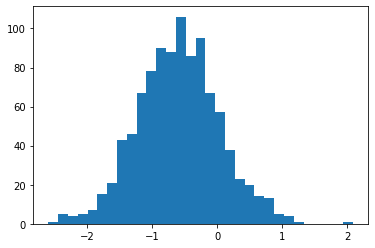

In [5]:
print("Mean field mean: {}, Mean field standard deviation: {}".format(variational_params_1d[0], np.exp(variational_params_1d[1])))
fig, ax = plt.subplots()
ax.hist(np.random.normal(variational_params_1d[0], np.exp(variational_params_1d[1]), 1000), bins=int(np.sqrt(1000)))
plt.show()

# Part 2

Question 1 was completed using the implementation of the log ensity from lecture 15. Similaryly, BBVI was implemented with the example from lecture 15.

In [6]:
###define rbf activation function
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [7]:
###Bayesian model parameterss
#covariance matrix of the Gaussian prior on weights
Sigma_W = 5**2 * np.eye(nn.D)
#Gaussian likelihood variance
sigma_y = 0.5**2
#number of data points
N = 12
#precision matrix of the Gaussian prior on weights
Sigma_W_inv = np.linalg.inv(Sigma_W)
#determinant of the covaraince matrix of the Gaussian prior on weights
Sigma_W_det = np.linalg.det(Sigma_W)

In [8]:
# Now need to do VI things
data = pd.read_csv("./HW7_data.csv")
y_train = data['y'].values
x_train = data['x'].values[np.newaxis,]

# No uncertainty
step_size = 1e-1
S = 50

print("STEP SIZE: {}, S: {}".format(step_size, S))
variational_params = variational_inference(Sigma_W, sigma_y, y_train, x_train, nn.forward, S=S, max_iteration=4001, step_size=step_size, verbose=True)
print("\n\n")

KeyError: 'y'

3) The plot of the neural network outputs are seen below.

In [ ]:
xs = np.linspace(-8, 8, 100)
fig, ax = plt.subplots()
outputs = []
sampled_weights = []
for i in range(100):
    weights = np.random.multivariate_normal(variational_params[:16], np.diag(np.exp(variational_params[16:])**2))
    output = nn.forward(weights[np.newaxis,], xs[np.newaxis,])[0][0] + np.random.normal(0, 0.5**2, 100)
    outputs.append(output)
    sampled_weights.append(weights)

lb_bayes = np.percentile(outputs, 2.5, axis=0)
ub_bayes = np.percentile(outputs, 97.5, axis=0)
ax.fill_between(xs, ub_bayes, lb_bayes, alpha=0.3)
ax.scatter(x_train, y_train, color='k')
plt.show()

In [ ]:
forward = nn.forward
def log_lklhd(W):
    S = W.shape[0]
    constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * N
    exponential = -0.5 * sigma_y**-2 * np.sum((y_train.reshape((1, 1, N)) - forward(W, x_train))**2, axis=2).flatten()
    return constant + exponential

log_likelihoods = []
for out in sampled_weights:
    log_likelihoods.append(log_lklhd(out[:16][np.newaxis,]))
print("4) POSTERIOR PREDICTIVE LOG-LIKELIHOOD: {}".format(np.mean(log_likelihoods)))
print("4) POSTERIOR PREDICTIVE LOG-LIKELIHOOD HW7 MODEL: -5.121776735095353")

5) We cannot really say if our posterior estimate is any good because our model missed a significant amount of epistemic uncertainty. Comparing it to the model from HW7, we see that model captures the epistemic and aleatoric uncertainty. Because of this, I would say that model is better. We would expect that the middle 95% predictive interval would be much larger where there is no data than where there is data. We do not see this. The model therefore captures the aleatoric uncertainty, but almost none of the epistemic uncertainty.

6) Potential convergence of HMC

In [ ]:
###define rbf activation function
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':2000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn.fit(x_train.reshape((1, -1)), y_train.reshape((1, -1)), params)

x_test = np.linspace(-8, 8, 100)
y_test = nn.forward(nn.weights, x_test.reshape((1, -1)))
plt.scatter(x_train, y_train, color='black', label='data')
plt.plot(x_test, y_test.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()

copy_of_weights = np.copy(nn.weights)

In [ ]:
mu = nn.forward(copy_of_weights, x_train[np.newaxis,])
fig, ax = plt.subplots()
xs = np.linspace(-8, 8, 100)
ax.plot(xs, nn.forward(copy_of_weights, xs[np.newaxis,])[0][0])
ax.scatter(x_train,y_train)

In [ ]:
nnn = Feedforward(architecture, random=random)
def log_joint(w, mu=mu, sig1=5., y=y, sig2=0.5, N=16, nn=nnn):
    print(w.shape)
    sig1_mat = sig1**2 * np.eye(N)
    mu = nn.forward(w, x_train[np.newaxis,])[0][0]
    prior = np.log(sp.stats.multivariate_normal.pdf(w, np.zeros(N), sig1_mat))
    likelihood = 0
    for i in range(len(y_train)):
        likelihood += np.log(sp.stats.norm.pdf(y_train[i], mu[i], sig2**2))
    
    return -prior - likelihood

In [ ]:
# Part 1
def K(p, M):
    d = len(p)
    M_mat = 1/M*np.eye(len(p))
    return 1/2*np.dot(p.T, np.dot(M_mat, p)) + 1/2*np.log(np.linalg.det(M_mat)) + d/2*np.log(2*np.pi)

def U(q):
    return np.array(np.log(2*np.pi) + np.linalg.norm(q)**2)/2

def U_prime(q, u_func=U):
    return 2*(q/u_func(q))

def H(q, p, M, u_func=U):
    return u_func(q) + K(p, M)

def hist_data(data, idx):
    return data[:,i]

In [ ]:
def hmc(steps, eps, l_steps, M, q, N, u_func=U, u_prime_func=U_prime, nn=None, x=None):
    acc = 0
    p = np.random.randn((N))*M
    if(nn == None):
        new_u_func = lambda x: u_func(x)
        u_prime_func = grad(new_u_func)
    else:
        q = np.copy(q[np.newaxis,])
        new_u_func = lambda x: u_func(x)
        u_prime_func = grad(new_u_func)

    qs = [np.copy(q)]

    for i in tqdm(range(steps)):
        # Random p
        p = np.random.randn((N))*M         
        
        p_prop = np.copy(p)
        q_prop = np.copy(q)

        # Leapfrog integration
        p_prop -= eps/2*u_prime_func(np.array(q))[0]
        for i in range(l_steps):
            q_prop += eps/M*p_prop
            p_prop -= eps*u_prime_func(np.array(q_prop))[0]
        p_prop -= eps/2*u_prime_func(np.array(q_prop))[0]

    
        # Reverse momentum
        p_prop = -p_prop
    
        alpha = K(p, M) - K(p_prop, M) + new_u_func(q) - new_u_func(q_prop)
        if(alpha > np.log(np.random.random())):
            acc += 1
            q = np.copy(q_prop)
            qs.append(q)
        else:
            qs.append(q)
    
    return np.array(qs), acc

In [ ]:
params = {'step_size':0.001, 
       'leapfrog_steps':50, 
       'total_samples':20, 
       'burn_in':.1, 
       'thinning_factor':2,
       'position_init': np.copy(copy_of_weights)}
fig, ax = plt.subplots()
xs = np.linspace(-8, 8, 100)
plt.plot(xs, nnn.forward(copy_of_weights, xs[np.newaxis,])[0][0])
plt.show()

sampled_qs, acc = hmc(params['total_samples'], params['step_size'], params['leapfrog_steps'],
             1, params['position_init'][0], len(params['position_init'][0]), log_joint, nn=nnn, x=x_train[0])

burn_in = int(len(sampled_qs)*params['burn_in'])
qs = np.array(sampled_qs[burn_in::params['thinning_factor']])
print("ACCEPTANCE RATE: {}".format(acc/params['total_samples']))

In [ ]:

new_nn = Feedforward(architecture, random=random)
fig, ax = plt.subplots()
xs = np.linspace(-8, 8, 100)
outs = []
for i in range(100):
    idx = np.random.choice(qs.shape[0])
    posterior_predictive = np.array(qs[idx][np.newaxis,])
    ys = new_nn.forward(posterior_predictive[0], xs[np.newaxis,])[0,0] + np.random.randn(100)*0.5**2
    outs.append(ys)

low_end = np.percentile(outs, 2.5, axis=0)
high_end = np.percentile(outs, 97.5, axis=0)
ax.fill_between(xs, low_end, high_end, alpha=0.3)
_ = plt.scatter(x_train, y_train, color='black', label='data')

In [ ]:
def log_likelihood(mu, sigma=0.5):
    return np.sum([np.log(sp.stats.norm.pdf(y_train[n], mu[n], sigma**2)) for n in range(len(mu))])

lvs = []
for i in range(len(qs)):
    posterior_predictive = np.array(qs[i][np.newaxis,])
    mu_vals = nn.forward(posterior_predictive[0], x_train[np.newaxis,])[0][0]
    lvs.append(log_likelihood(mu_vals))

print("5) POSTERIOR PREDICTIVE LOG-LIKELIHOOD: {}".format(np.mean(lvs)))

In [ ]:
# Trace plots
fig, ax = plt.subplots()
ax.plot(qs[:,0])